point cloud data is stored as a 2D matrix
each row has 3 values i.e. the x, y, z value for a point

Project has to be submitted to github in the private folder assigned to you
Readme file should have the numerical values as described in each task
Create a folder to store the images as described in the tasks.

Try to create commits and version for each task.

In [1]:
import matplotlib
import numpy as np
from scipy.spatial import KDTree
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler

from sklearn.mixture import GaussianMixture

In [2]:
#%% utility functions
def show_cloud(points_plt):
    ax = plt.axes(projection='3d')
    ax.scatter(points_plt[:,0], points_plt[:,1], points_plt[:,2], s=0.01)
    plt.show()

def show_scatter(x,y):
    plt.scatter(x, y)
    plt.show()

def get_ground_level(pcd, dataset):

    z_vals = pcd[:, 2].reshape(-1, 1) # extract z values 
    # fit a 2 component GMM: one for ground/tracks, one for elevated structures
    gmm = GaussianMixture(n_components=2, random_state=0) 
    gmm.fit(z_vals)
    means = gmm.means_.flatten() # convert 2D array to 1D
    ground_mean = np.min(means)  # lower mean is ground/tracks
    elevated_mean = np.max(means)
    # boundary between ground and elevated
    boundary = (ground_mean + elevated_mean) / 2

    print(f"{dataset}: ground mean = {ground_mean}")
    print(f"{dataset}: elevated mean = {elevated_mean}")
    print(f"{dataset}: semantic threshold = {boundary}")

    plt.hist(z_vals, bins=100)
    plt.axvline(ground_mean, color='red', linestyle='--', linewidth=1.5, label='Ground mean')
    plt.axvline(elevated_mean, color='green', linestyle='--', linewidth=1.5, label='Elevated mean')
    plt.axvline(boundary, color='blue', linestyle='--', linewidth=1.5, label='Semantic threshold')
    plt.xlabel('Height (z)')
    plt.ylabel('Number of points')
    plt.title(f'{dataset}: Height Distribution to Find Ground Level')
    plt.legend()
    plt.show()

    # Mask for points above the semantic threshold
    mask = pcd[:,2] > boundary
    return mask, boundary

In [3]:
#%% read file containing point cloud data
pcd = np.load("dataset1.npy")

pcd.shape

(72067, 3)

In [4]:
pcd2 = np.load("dataset2.npy")

pcd2.shape

(84588, 3)

In [5]:
pcd[:5]  # [x,y,z] aka 0,1,2

array([[31.405, 80.054, 61.247],
       [30.961, 80.243, 61.185],
       [30.599, 80.412, 61.174],
       [30.258, 80.577, 61.145],
       [33.393, 80.217, 61.218]])

In [6]:
pcd2[:5]

array([[1.17020000e+01, 3.99999972e-03, 6.11420000e+01],
       [1.19060000e+01, 3.04000000e-01, 6.11520000e+01],
       [1.40860000e+01, 3.00000003e-02, 6.11040000e+01],
       [1.19350000e+01, 6.48000000e-01, 6.11070000e+01],
       [1.28780000e+01, 5.88000000e-01, 6.11780000e+01]])

In [7]:
# show z values
pcd[:5, 2] # first 5 rows of the z column

array([61.247, 61.185, 61.174, 61.145, 61.218])

In [8]:
#%% show downsampled data in external window
%matplotlib inline
#show_cloud(pcd)
#show_cloud(pcd[::2]) # keep every 10th point

Dataset 1: ground mean = 61.26906038444822
Dataset 1: elevated mean = 67.41653964548783
Dataset 1: semantic threshold = 64.34280001496802


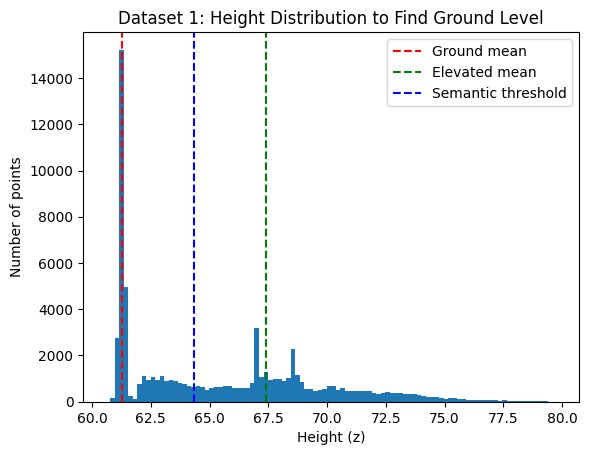

Dataset 2: ground mean = 61.23265779119356
Dataset 2: elevated mean = 67.44447711757516
Dataset 2: semantic threshold = 64.33856745438436


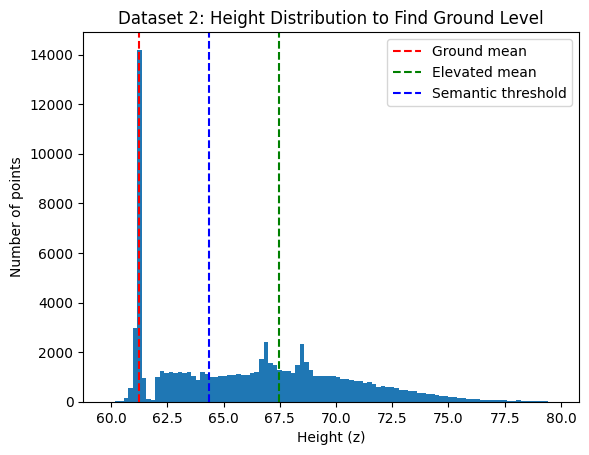

In [9]:
'''
Task 1 (3)
find the best value for the ground level
One way to do it is useing a histogram 
np.histogram

update the function get_ground_level() with your changes

For both the datasets
Report the ground level in the readme file in your github project
Add the histogram plots to your project readme
'''

# dataset 1
mask1, threshold1 = get_ground_level(pcd, "Dataset 1")
pcd_above_ground = pcd[mask1]

# dataset 2
mask2, threshold2 = get_ground_level(pcd2, "Dataset 2")
pcd2_above_ground = pcd2[mask2]

In [10]:
pcd_above_ground.shape

(37376, 3)

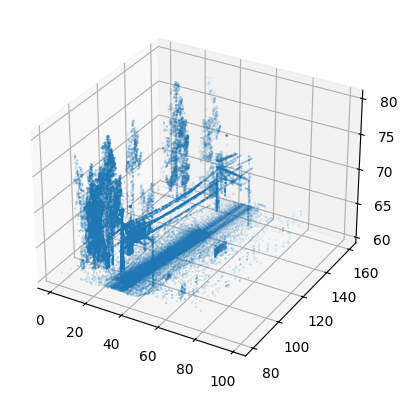

In [11]:
# original Dataset 1
show_cloud(pcd)

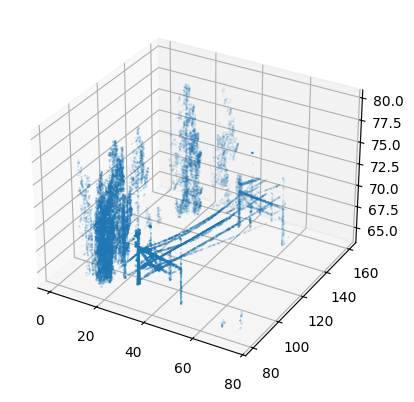

In [12]:
#%% side view
# after ground removal Dataset 1
show_cloud(pcd_above_ground)

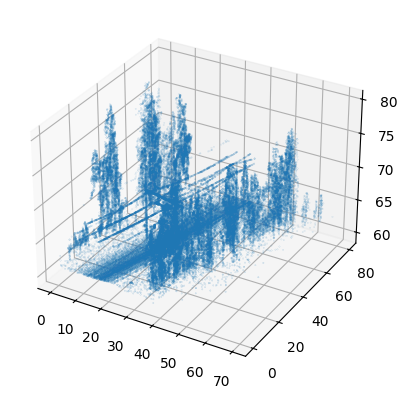

In [13]:
# Dataset 2 before ground removal
#%% show downsampled data in external window
%matplotlib inline
show_cloud(pcd2)
#show_cloud(pcd2[::10]) # keep every 10th point

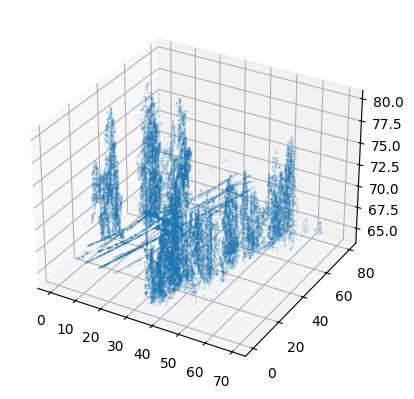

In [14]:
#%% Datset 2 side view, after ground removal
show_cloud(pcd2_above_ground)

TASK 2


In [ ]:
'''
Task 2 (+1)

Find an optimized value for eps.
Plot the elbow and extract the optimal value from the plot
Apply DBSCAN again with the new eps value and confirm visually that clusters are proper

https://www.analyticsvidhya.com/blog/2020/09/how-dbscan-clustering-works/
https://machinelearningknowledge.ai/tutorial-for-dbscan-clustering-in-python-sklearn/

For both the datasets
Report the optimal value of eps in the Readme to your github project
Add the elbow plots to your github project Readme
Add the cluster plots to your github project Readme
'''

# plot the elbow in order to find best eps
def elbow_plot(X, min_samples): # X is dataset

    #scale
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    neighbors = NearestNeighbors(n_neighbors=min_samples) 
    neighbors_fit = neighbors.fit(X_scaled)
    distances, indices = neighbors_fit.kneighbors(X_scaled) 

    k_dist = distances[:, -1] # -1 means last column
    sorted_k_dist = np.sort(k_dist)[::-1] # reverse sort

    # extract opitmal value from the plot
    distances = sorted_k_dist
    if len(distances) > 2:
        first_deriv = np.diff(distances)
        second_deriv = np.diff(first_deriv)

        elbow = np.argmax(np.abs(second_deriv)) +1 # +1 to account for the diff reducing length
        print(f"Elbow found at index: {elbow}")

    #plot
    plt.plot(sorted_k_dist)
    plt.xlabel("Points sorted by distance")
    plt.ylabel("Distance")
    plt.title("Elbow Plot")
    plt.grid(True)
    plt.legend()
    plt.show()    
    return 

Elbow found at index: 1


C:\Users\natal\AppData\Local\Temp\ipykernel_21112\20822054.py:46: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


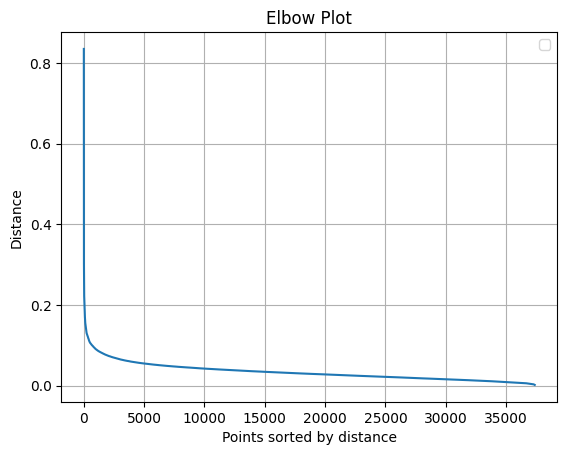

In [16]:
# Dataset 1
elbow_plot(pcd_above_ground, 6)

Elbow found at index: 4


C:\Users\natal\AppData\Local\Temp\ipykernel_21112\20822054.py:46: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


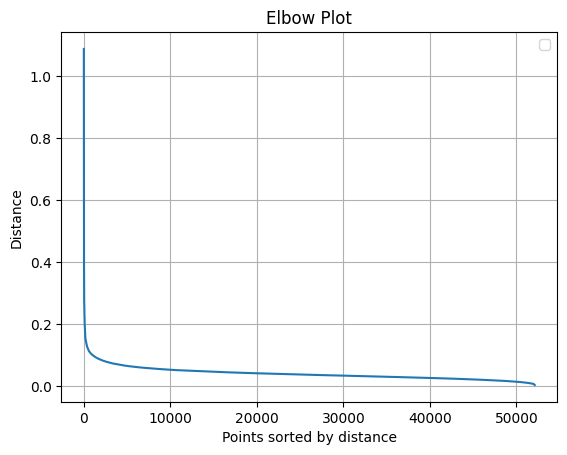

In [17]:
# Dataset 2
elbow_plot(pcd2_above_ground, 6)

In [18]:
# apply_dbscan(pcd_above_ground, 10)

In [19]:
def apply_dbscan(dataset_name, dataset, optimal_eps):

    # scale the data
    scaler = StandardScaler()
    pcd_scaled = scaler.fit_transform(dataset)

    # find the elbow
    better_clustering = DBSCAN(eps = optimal_eps, min_samples=6).fit(pcd_scaled)

    #%%
    new_clusters = len(set(better_clustering.labels_)) - (1 if -1 in better_clustering.labels_ else 0)
    new_colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, new_clusters)]

    # %%
    # Plotting resulting clusters
    plt.figure(figsize=(10,10))
    plt.scatter(dataset[:,0], 
                dataset[:,1],
                c=better_clustering.labels_,
                cmap=matplotlib.colors.ListedColormap(new_colors),
                s=2)


    plt.title(''f'{dataset_name}: DBSCAN: %d clusters' % new_clusters,fontsize=20)
    plt.xlabel('x axis',fontsize=14)
    plt.ylabel('y axis',fontsize=14)
    plt.show()

    return better_clustering


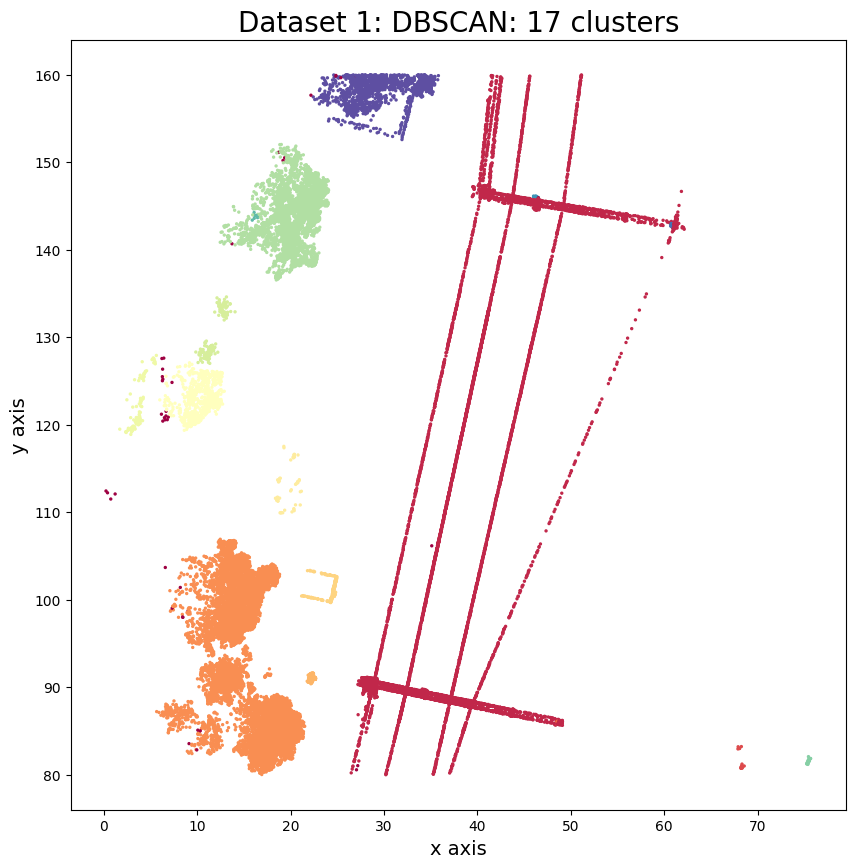

In [20]:
# DATASET 1
better_clustering = apply_dbscan("Dataset 1", pcd_above_ground, optimal_eps=0.16)

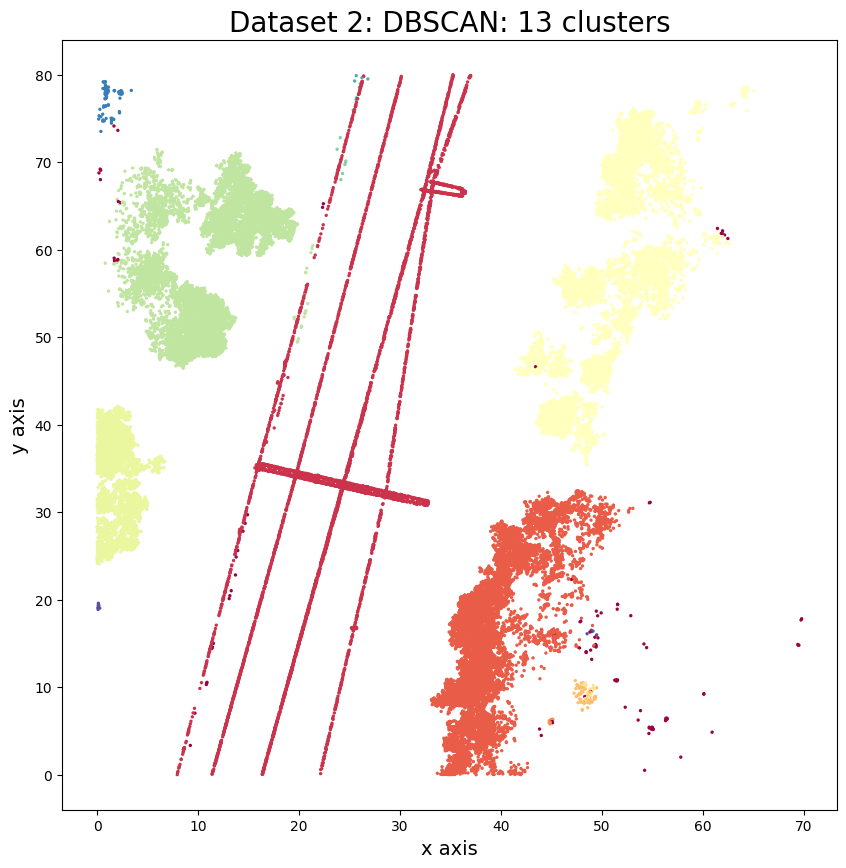

In [21]:
# DATASET 2
better_clustering2 = apply_dbscan("Dataset 2", pcd2_above_ground, optimal_eps=0.155)
